<a href="https://colab.research.google.com/github/paolapt/mtus/blob/main/Copy_of_Semifinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#base, working (do not move)

##imports

In [ ]:
!pip install stable_baselines3[extra]
!pip install --upgrade gym stable-baselines3
!pip install 'shimmy>=2.0'

import gym
from gym import Env
from gym.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete

import numpy as np
import random
import os

from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

from scipy.integrate import trapezoid

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 15.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


##deterministic code

###rewritten

In [ ]:
def get_quality(q0, landa, t, decay_type="exponential", sigma=0.0):
    if decay_type == "exponential":
        base_q = q0 * np.exp(-landa * t)
    elif decay_type == "linear":
        base_q = np.maximum(q0 - landa * t, 0)
    else:
        raise ValueError("Invalid decay_type")
    noise = np.random.normal(0, sigma, size=t.shape)
    return base_q + noise

def get_demand(D0, alpha, beta, price, quality, sigma_d=0.0):
    noise = np.random.normal(0, sigma_d, size=quality.shape)
    return np.maximum(D0 - alpha * price + beta * quality + noise,0) #ensures demand isnt negative


In [ ]:
def simrevenue(q0=0.92, landa=0.0216, D0=6.73, alpha=4.13, beta=4.13,
                            p=1.49, Cp=0.05, C0=1, Q0=240, T=3, Tm=2,
                            decay_type="exponential"):
    thetastar = (beta * q0 * (np.exp(-landa * T*24) - np.exp(-landa * Tm*24))) / (2 * alpha * landa * p * (T - Tm) * 24) + (2 * alpha * p - D0) / (2 * alpha * p)
    print(thetastar)
    #upper bound of theta*, from the constraint
    theta_max = (Q0 - (beta * q0 * (1 - np.exp(-landa * T*24)) / landa) - (D0 - alpha * p) * T*24) / (alpha * p * (T*24 - Tm*24))
    print(theta_max)
    theta = min(thetastar, theta_max)

    t_values1 = np.linspace(0, Tm*24, 1000)
    quality1 = get_quality(q0, landa, t_values1, decay_type)
    demand1 = get_demand(D0, alpha, beta, p, quality1)
    integrated_demand1 = trapezoid(demand1, t_values1)

    t_values3 = np.linspace(Tm*24, T*24, 1000)
    adjusted_price = p * (1 - theta)
    quality3 = get_quality(q0, landa, t_values3, decay_type)
    demand3 = get_demand(D0, alpha, beta, adjusted_price, quality3)
    integrated_demand3 = trapezoid(demand3, t_values3)

    revenue = (
        p * integrated_demand1 +
        adjusted_price * integrated_demand3 -
        (Q0 - integrated_demand1) * Cp -
        Q0 * C0
    )

    return {
        "theta": theta,
        #"theta_max": theta_max,
        "integrated_demand1": integrated_demand1,
        "integrated_demand3": integrated_demand3,
        "total_demand": integrated_demand1 + integrated_demand3,
        "revenue": revenue
    }


####test: 3 period

In [ ]:
result_det = simrevenue()
print("Deterministic Revenue:", result_det["revenue"])
print("Theta:", result_det["theta"])
print("Integrated Demand 1:", result_det["integrated_demand1"])
print("Integrated Demand 3:", result_det["integrated_demand3"])
print("Total Demand:", result_det["total_demand"])


0.36775087614510976
0.4045082643540219
Deterministic Revenue: 53.405752145582994
Theta: 0.36775087614510976
Integrated Demand 1: 141.19524123169884
Integrated Demand 3: 93.37611496938469
Total Demand: 234.57135620108352


####test: 10 period

In [ ]:
result_det = simrevenue(q0=0.95, landa=0.0067, D0=9.79, alpha=1.83, beta=1.83,
                            p=4.5, Cp=0.05, C0=3.5, Q0=740, T=10, Tm=7,
                            decay_type="exponential")
print("Deterministic Revenue:", result_det["revenue"])
print("Theta:", result_det["theta"])
print("Integrated Demand 1:", result_det["integrated_demand1"])
print("Integrated Demand 3:", result_det["integrated_demand3"])
print("Total Demand:", result_det["total_demand"])


0.37841587331124343
0.26865780432400427
Deterministic Revenue: 357.9410592399822
Theta: 0.26865780432400427
Integrated Demand 1: 436.5281124118271
Integrated Demand 3: 303.47190675844763
Total Demand: 740.0000191702748


##reusable testing

In [ ]:
import os
import gym
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy

class RewardTrackerCallback(BaseCallback):
    def __init__(self):
        super().__init__()
        self.episodic_rewards = []
        self.current_reward = 0

    def _on_step(self) -> bool:
        self.current_reward += self.locals['rewards'][0]
        if self.locals['dones'][0]:
            self.episodic_rewards.append(self.current_reward)
            self.current_reward = 0
        return True

def plot_average_rewards(rewards, window=1000):
    averages = []
    for i in range(0, len(rewards), window):
        window_rewards = rewards[i:i+window]
        averages.append(sum(window_rewards) / len(window_rewards))
    plt.plot(averages)
    plt.xlabel(f'{window} Episodes')
    plt.ylabel('Average Reward')
    plt.title('Average Episodic Rewards Over Time')
    plt.show()

In [ ]:
def run_test(env_kwargs, total_timesteps=100_000):
    env = PromotionEnv(**env_kwargs)

    #create the model
    model = DQN('MlpPolicy', env,
                gamma=0.99,
                learning_rate=0.01,
                buffer_size=50000,
                exploration_fraction=0.2,
                exploration_final_eps=0.02,
                exploration_initial_eps=1.0,
                verbose=1)

    #create and apply callback
    callback = RewardTrackerCallback()
    model.learn(total_timesteps=total_timesteps, callback=callback)

    #plots average rewards
    plot_average_rewards(callback.episodic_rewards)

    #evaluates created policy
    mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=100)
    print(f"\nMean Reward over 100 eval episodes: {mean_reward:.2f}")

    #best actions through episode
    state = env.reset()
    done = False
    t = 1
    print("\nActions by period:")
    while not done:
        action, _ = model.predict(state)
        state, reward, done, info = env.step(action)
        print(f"Time Period: {t}, Best Action (Discount): {action}, State: {state}")
        t += 1
        if done:
            print("Best action at the last time period:", action)

    env.close()
    return model

# optimal discounting for one day

In [ ]:
##only to have a rough idea of what the optimal discount should be, given a specific day where we want the discount to occur
def mindiscount_sellout(env_class, env_kwargs, DD):
    env_kwargs = env_kwargs.copy()
    env_kwargs["DD"] = DD

    for discount in range(100):
        env = env_class(**env_kwargs)
        obs, info = env.reset()

        done = False
        total_reward = 0

        print(f"\nTesting discount: {discount}%")
        while not done:
            current_day = env.T - env.period_length + 1

            if current_day == DD:
                obs, reward, terminated, truncated, _ = env.step(discount)
                print(f"Day {current_day} (step): Inventory={env.state[0]}, Reward={reward:.2f}")
            else:
                obs, reward, terminated, truncated, _ = env.advance()
                print(f"Day {current_day} (advance): Inventory={env.state[0]}, Reward={reward:.2f}")

            total_reward += reward
            done = terminated or truncated

        final_inventory = env.state[0]
        print(f"Discount {discount:2d}% -> Final inventory: {final_inventory}, Total reward: {total_reward:.2f}, Final state: {env.state}")

        if final_inventory == 0:
            print(f"Sold out at discount: {discount}%")
            return discount

    print("No discount sold out the inventory.")
    return None


In [ ]:
import gym
import numpy as np
from gym.spaces import Discrete, MultiDiscrete
from scipy.integrate import trapezoid


class PromotionEnv(gym.Env):
    def __init__(self, Q0=240, T=3, DD=2,
                 D0=6.73, alpha=4.13, beta=4.13,
                 p=1.49, Cp=0.05, C0=1, Cs=0,
                 q0=0.92, landa=0.0216, decay_type="exponential",
                 sigma=0.0, mu_d=0.0, sigma_d=0.0, LC=0):
        super().__init__()
        self.Q0 = Q0
        self.T = T
        self.DD = DD
        self.D0 = D0
        self.alpha = alpha
        self.beta = beta
        self.p = p
        self.Cp = Cp
        self.C0 = C0
        self.Cs = Cs
        self.q0 = q0
        self.landa = landa
        self.decay_type = decay_type
        self.sigma = sigma
        self.mu_d = mu_d
        self.sigma_d = sigma_d
        self.LC = LC

        self.action_space = Discrete(100)  # 0-99% discount
        self.observation_space = MultiDiscrete([Q0+1, T+1, 100])  # inv, time left, last disc

        self.reset()

    def step(self, action):
        day = self.T - self.period_length + 1
        #only apply the agent's discount on DD
        if self.DD is not None:
            day = self.T - self.period_length + 1
            if day != self.DD:
                action = 0  #force discount to 0 outside of DD


        self.last_discount = action
        reward, done = self._apply_discount_and_advance(self.last_discount)
        return self.state.copy(), reward, done, False, {}

    def advance(self):
        day = self.T - self.period_length + 1
        if day == self.DD:
            raise RuntimeError(f"advance() NOT allowed on day {self.DD}, agent action required")

        discount = self.last_discount if day > self.DD else 0
        reward, done = self._apply_discount_and_advance(discount)
        return self.state.copy(), reward, done, False, {}

    def _apply_discount_and_advance(self, discount):
        price = self.p * (100 - discount) / 100

        t_start = (self.T - self.period_length) * 24
        t_end = t_start + 24
        t_values = np.linspace(t_start, t_end, 1000)

        quality = get_quality(self.q0, self.landa, t_values, self.decay_type, self.sigma)
        demand = get_demand(self.D0, self.alpha, self.beta, price, quality, self.mu_d, self.sigma_d)

        integrated_demand = trapezoid(demand, t_values)
        units_sold = min(self.state[0], int(integrated_demand))

        reward = units_sold * price


        day = self.T - self.period_length + 1 #markdown cost and staffing cost ONLY on discount day if discount > 0
        if discount > 0 and day == self.DD:
            reward -= self.Cp * self.state[0]
            reward -= self.Cs

        #if not hasattr(self, 'applied_operational_cost') or not self.applied_operational_cost:
            #reward -= self.C0 * self.Q0
            #self.applied_operational_cost = True

        self.state[0] -= units_sold

        self.period_length -= 1
        self.state[1] = self.period_length
        self.state[2] = discount

        done = self.period_length <= 0 or self.state[0] <= 0

        if done:
            reward -= self.LC * self.state[0]

        return reward, done


    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.state = np.array([self.Q0, self.T, 0], dtype=int)
        self.period_length = self.T
        self.last_discount = 0
        #self.applied_operational_cost = False
        return self.state.copy(), {}


In [ ]:
env_kwargs = {
    'Q0': 740,
    'T': 10,
    'D0': 9.79,
    'alpha': 1.83,
    'beta': 1.83,
    'p': 4.5,
    'Cp': 0.05,
    'C0': 3.5,
    'Cs': 0,
    'q0': 0.95,
    'landa': 0.0067,
    'LC': 0.5
}

DD=8
#minimum discount on day 8 that sells everything
optimal_discount = mindiscount_sellout(PromotionEnv, env_kwargs, DD=DD)
print(f"min discount to sell out starting from day {DD}: {optimal_discount}%")



Testing discount: 0%
Day 1 (advance): Inventory=665, Reward=337.50
Day 2 (advance): Inventory=595, Reward=315.00
Day 3 (advance): Inventory=530, Reward=292.50
Day 4 (advance): Inventory=469, Reward=274.50
Day 5 (advance): Inventory=412, Reward=256.50
Day 6 (advance): Inventory=358, Reward=243.00
Day 7 (advance): Inventory=306, Reward=234.00
Day 8 (step): Inventory=257, Reward=220.50
Day 9 (advance): Inventory=210, Reward=211.50
Day 10 (advance): Inventory=164, Reward=125.00
Discount  0% -> Final inventory: 164, Total reward: 2510.00, Final state: [164   0   0]

Testing discount: 1%
Day 1 (advance): Inventory=665, Reward=337.50
Day 2 (advance): Inventory=595, Reward=315.00
Day 3 (advance): Inventory=530, Reward=292.50
Day 4 (advance): Inventory=469, Reward=274.50
Day 5 (advance): Inventory=412, Reward=256.50
Day 6 (advance): Inventory=358, Reward=243.00
Day 7 (advance): Inventory=306, Reward=234.00
Day 8 (step): Inventory=255, Reward=211.91
Day 9 (advance): Inventory=206, Reward=218.30

In [ ]:
env_kwargs = {
}

DD=3
#minimum discount on day 8 that sells everything
optimal_discount = mindiscount_sellout(PromotionEnv, env_kwargs, DD=DD)
print(f"min discount to sell out starting from day {DD}: {optimal_discount}%")



Testing discount: 0%
Day 1 (advance): Inventory=156, Reward=125.16
Day 2 (advance): Inventory=100, Reward=83.44
Day 3 (step): Inventory=61, Reward=58.11
Discount  0% -> Final inventory: 61, Total reward: 266.71, Final state: [61  0  0]

Testing discount: 1%
Day 1 (advance): Inventory=156, Reward=125.16
Day 2 (advance): Inventory=100, Reward=83.44
Day 3 (step): Inventory=60, Reward=54.00
Discount  1% -> Final inventory: 60, Total reward: 262.60, Final state: [60  0  1]

Testing discount: 2%
Day 1 (advance): Inventory=156, Reward=125.16
Day 2 (advance): Inventory=100, Reward=83.44
Day 3 (step): Inventory=58, Reward=56.33
Discount  2% -> Final inventory: 58, Total reward: 264.93, Final state: [58  0  2]

Testing discount: 3%
Day 1 (advance): Inventory=156, Reward=125.16
Day 2 (advance): Inventory=100, Reward=83.44
Day 3 (step): Inventory=57, Reward=57.15
Discount  3% -> Final inventory: 57, Total reward: 265.75, Final state: [57  0  3]

Testing discount: 4%
Day 1 (advance): Inventory=156



---
JULY 28



#TEST 1 DISCOUNT

In [ ]:

class RewardTrackerCallback(BaseCallback):
    def __init__(self):
        super().__init__()
        self.episodic_rewards = []
        self.episode_reward = 0

    def _on_step(self) -> bool:
        self.episode_reward += self.locals["rewards"][0]
        if self.locals["dones"][0]:
            self.episodic_rewards.append(self.episode_reward)
            self.episode_reward = 0
        return True


def plot_average_rewards(rewards, window=1000):
    averages = []
    for i in range(0, len(rewards), window):
        window_rewards = rewards[i:i+window]
        averages.append(sum(window_rewards) / len(window_rewards))
    plt.plot(averages)
    plt.xlabel(f'{window} Episodes')
    plt.ylabel('Average Reward')
    plt.title('Average Episodic Rewards Over Time')
    plt.show()

def run_test(env_kwargs, total_timesteps=100_000,verbose=1):
    env = PromotionEnv(**env_kwargs)

    model = DQN('MlpPolicy', env,
                gamma=0.99,
                learning_rate=0.001,
                buffer_size=50000,
                exploration_fraction=0.2,
                exploration_final_eps=0.02,
                exploration_initial_eps=1.0,
                verbose=verbose)

    callback = RewardTrackerCallback()
    model.learn(total_timesteps=total_timesteps, callback=callback)

    plot_average_rewards(callback.episodic_rewards)

    mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=100)
    print(f"\nMean Reward over 100 eval episodes: {mean_reward:.2f}")

    state, _ = env.reset()
    done = False
    t = 1
    print("\nBest actions by period:")
    while not done:
        action, _ = model.predict(state)
        state, reward, done, _, _ = env.step(action)
        print(f"Time Period: {t}, Action taken: {state[2]}, State: {state}")
        t += 1

    env.close()
    return model, callback

In [ ]:
import gym
import numpy as np
from gym.spaces import Discrete, MultiDiscrete
from scipy.integrate import trapezoid

class PromotionEnv(gym.Env):
    def __init__(self, Q0=240, T=3, DD=3, D0=6.73, alpha=4.13, beta=4.13,
                 p=1.49, Cp=0.05, C0=1, Cs=0,
                 q0=0.92, landa=0.0216, decay_type="exponential",
                 sigma=0.0, mu_d=0.0, sigma_d=0.0, LC=0):
        super().__init__()
        self.Q0 = Q0 #initial inventory
        self.T = T #total # of days
        self.DD = DD #target discount day
        self.D0 = D0 #inituial demand
        self.alpha = alpha #demand sensitivity
        self.beta = beta #demand sensiivity
        self.p = p #price
        self.Cp = Cp #per unit changing cost
        self.C0 = C0  #operational cost
        self.Cs = Cs #staffing cost
        self.q0 = q0 #initial quality
        self.landa = landa #quality decay
        self.decay_type = decay_type
        self.sigma = sigma #noise in quality
        self.sigma_d = sigma_d #noise in demand
        self.LC = LC #leftover cost

        self.action_space = Discrete(100)
        self.observation_space = MultiDiscrete([Q0 + 1, T + 1, 100])

        self.reset()

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.inventory = self.Q0
        self.time_left = self.T
        self.state = np.array([self.inventory, self.time_left, 0], dtype=int)

        self.day_discounts = {}  #dict with the discounts applied each day like 3:30 is day 3 30% off
        return self.state.copy(), {}

    def step(self, action):
        day = self.T - self.time_left + 1. #current day we're at
        penalty = 0 #initial penalty is 0
        new_discount_today = False
        discount = int(action)

        previous_discounts = [self.day_discounts[d] for d in self.day_discounts if d < day] #list of discounts applied before this day
        last_discount = max(previous_discounts) if previous_discounts else 0 #last discount is biggest one (since we can only
        #have increasing discounts, or 0 if there's no previous discounts)

        if discount < last_discount:
            penalty = - ((self.p * self.Q0) / self.T)/2 #apply penalty if we reduce discount

        #if we have a nonzero discount, and it's in our allowed discount days, record the discount on the dict
        #else apply a penalty because we are discounting on a day it's not allowed
        if discount > 0:
            if isinstance(self.DD, (tuple, list)) and day in self.DD and day not in self.day_discounts: #multiple day discounts
                self.day_discounts[day] = discount
                new_discount_today = True
            elif isinstance(self.DD, int) and day == self.DD and self.DD not in self.day_discounts: #one day discount
                self.day_discounts[day] = discount
                new_discount_today = True
            elif self.DD is None: #no restrictions
                self.day_discounts[day] = discount
                new_discount_today = True
            else:
                penalty = - ((self.p * self.Q0) / self.T)/2 #penalty scales depending on initial quantity and time horizon
                # so it's not too big or too small

        if self.day_discounts: #check if any discount has been applied and is on the dict
            valid_days = [d for d in self.day_discounts if d <= day] #get the days from the dict
            current_discount = self.day_discounts[max(valid_days)] if valid_days else 0 #current discount
            #has to be the latest one done on a valid day
        else:
            current_discount = 0 #else no discounts have happened

        revenue = self.totalreward(current_discount, new_discount_today) #revenue depends on our current discount
        # and we have to include flag to see if additional costs apply
        reward = revenue + penalty #add penalty if we decreased the discount or if discoutn was on wrong day

        #add small bonus for correct discount day
        if new_discount_today:
            if isinstance(self.DD, (tuple, list)) and day in self.DD: #for multi discount scenario
                reward += ((self.p * self.Q0) / self.T)/4 #again we scale based on time horizon and initial quantity
            elif isinstance(self.DD, int) and day == self.DD: #when there's one allowed day
                reward += ((self.p * self.Q0) / self.T)/4

        self.time_left -= 1 #advance time
        done = self.time_left <= 0 or self.inventory <= 0 #we're done if there's no time left or inventory is empty

        self.state = np.array([self.inventory, self.time_left, current_discount]) #update the state

        if done and self.inventory > 0:
            reward -= self.LC * self.inventory #penalize leftover inventory
            if max(self.day_discounts.values(), default=0) == 0:
                reward -= ((self.p * self.Q0) / self.T)/2 #if we never discounted anything, also add a penalty

        return self.state.copy(), reward, done, False, {}

    def totalreward(self, discount, new_discount_today):
        price = self.p * (100 - discount) / 100 #new price
        t_start = (self.T - self.time_left) * 24
        t_end = t_start + 24
        t_values = np.linspace(t_start, t_end, 1000)

        quality = get_quality(self.q0, self.landa, t_values, self.decay_type, self.sigma)
        demand = get_demand(self.D0, self.alpha, self.beta, price, quality, self.sigma_d)

        integrated_demand = trapezoid(demand, t_values)
        units_sold = min(self.inventory, int(integrated_demand)) #units sold cannot be bigger than what we have available
        revenue = units_sold * price

        if new_discount_today: #if there's a new discount, include costs associated (staffing, price change)
            revenue -= self.Cp * self.inventory
            revenue -= self.Cs

        self.inventory -= units_sold #update inventory
        return revenue


Streaming output truncated to the last 5000 lines.
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.231    |
|    n_updates        | 23980    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.98     |
|    ep_rew_mean      | 289      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 33396    |
|    fps              | 417      |
|    time_elapsed     | 230      |
|    total_timesteps  | 96035    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.34     |
|    n_updates        | 23983    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.98     |
|    ep_rew_mean      | 289      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 33400    |
|   

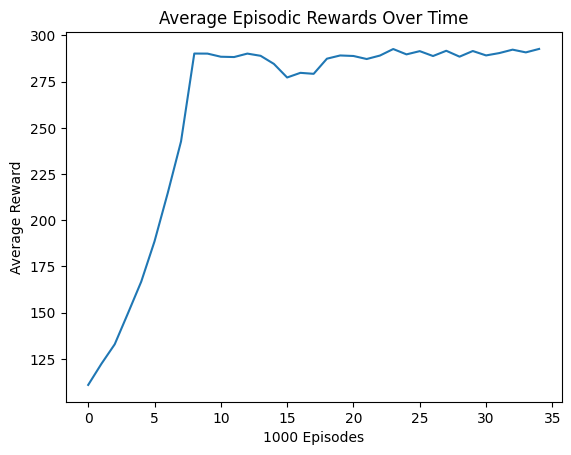


Mean Reward over 100 eval episodes: 297.54

Best actions by period:
Time Period: 1, Action taken: 0, State: [156   2   0]
Time Period: 2, Action taken: 17, State: [75  1 17]
Time Period: 3, Action taken: 23, State: [ 2  0 23]


(<stable_baselines3.dqn.dqn.DQN at 0x7f76425cd2d0>,
 <__main__.RewardTrackerCallback at 0x7f763705ef90>)

In [ ]:
run_test(env_kwargs={
    'DD': None,
}, total_timesteps=100000)

Streaming output truncated to the last 5000 lines.
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 2.01     |
|    n_updates        | 34141    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.98     |
|    ep_rew_mean      | 2.55e+03 |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 13756    |
|    fps              | 425      |
|    time_elapsed     | 321      |
|    total_timesteps  | 136708   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 4.46     |
|    n_updates        | 34151    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.98     |
|    ep_rew_mean      | 2.55e+03 |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 13760    |
|   

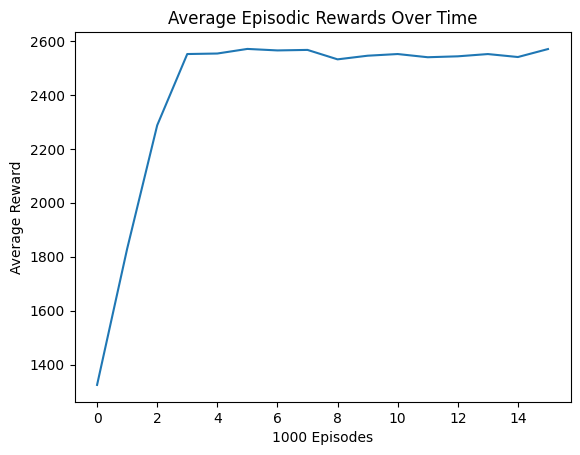


Mean Reward over 100 eval episodes: 2596.14

Best actions by period:
Time Period: 1, Best Action (Discount): 0, State: [665   9   0]
Time Period: 2, Best Action (Discount): 0, State: [595   8   0]
Time Period: 3, Best Action (Discount): 0, State: [530   7   0]
Time Period: 4, Best Action (Discount): 0, State: [469   6   0]
Time Period: 5, Best Action (Discount): 0, State: [412   5   0]
Time Period: 6, Best Action (Discount): 0, State: [358   4   0]
Time Period: 7, Best Action (Discount): 0, State: [306   3   0]
Time Period: 8, Best Action (Discount): 28, State: [201   2  28]
Time Period: 9, Best Action (Discount): 15, State: [98  1 28]
Time Period: 10, Best Action (Discount): 15, State: [ 0  0 28]
Best action at the last time period: 15


(<stable_baselines3.dqn.dqn.DQN at 0x781401ac7110>,
 <__main__.RewardTrackerCallback at 0x781401d8cfd0>)

In [ ]:
run_test(env_kwargs={
    'Q0': 740,
    'T': 10,
    'D0': 9.79,
    'alpha': 1.83,
    'beta': 1.83,
    'p': 4.5,
    'Cp': 0.05,
    'C0': 3.5,
    'Cs': 0,
    'q0': 0.95,
    'landa': 0.0067,
    'DD': 8,
    'LC': 0
}, total_timesteps=150000)

Streaming output truncated to the last 5000 lines.
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0704   |
|    n_updates        | 11473    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3        |
|    ep_rew_mean      | 288      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 15336    |
|    fps              | 356      |
|    time_elapsed     | 129      |
|    total_timesteps  | 46008    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0582   |
|    n_updates        | 11476    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3        |
|    ep_rew_mean      | 289      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 15340    |
|   

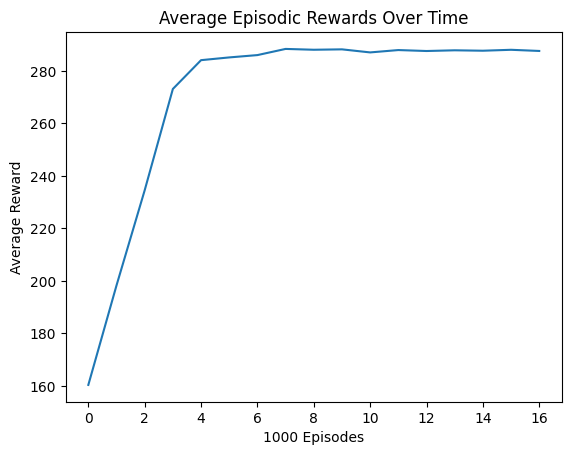


Mean Reward over 100 eval episodes: 291.12

Best actions by period:
Time Period: 1, Best Action (Discount): 0, State: [156   2   0]
Time Period: 2, Best Action (Discount): 0, State: [100   1   0]
Time Period: 3, Best Action (Discount): 34, State: [11  0 34]
Best action at the last time period: 34


(<stable_baselines3.dqn.dqn.DQN at 0x798f7011aad0>,
 <__main__.RewardTrackerCallback at 0x798f7016aa50>)

In [ ]:
run_test(env_kwargs = {}, total_timesteps=50000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.75     |
|    ep_rew_mean      | 1.21e+03 |
|    exploration_rate | 0.999    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2822     |
|    time_elapsed     | 0        |
|    total_timesteps  | 39       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.5      |
|    ep_rew_mean      | 1.13e+03 |
|    exploration_rate | 0.998    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 2724     |
|    time_elapsed     | 0        |
|    total_timesteps  | 76       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.42     |
|    ep_rew_mean      | 1.11e+0

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 2.14     |
|    n_updates        | 34140    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.99     |
|    ep_rew_mean      | 2.56e+03 |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 13756    |
|    fps              | 385      |
|    time_elapsed     | 354      |
|    total_timesteps  | 136704   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 3.65     |
|    n_updates        | 34150    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.99     |
|    ep_rew_mean      | 2.56e+03 |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 13760    |
|   

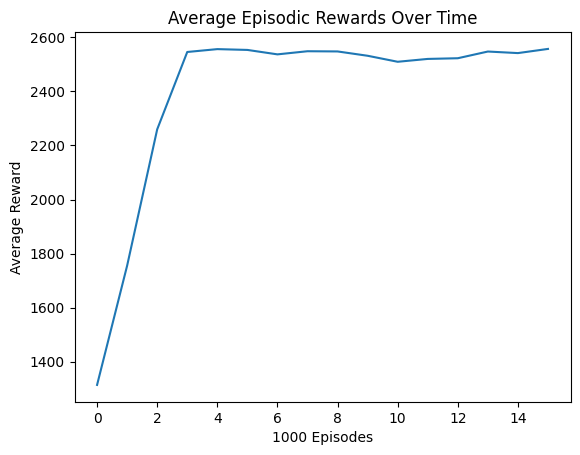

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(



Mean Reward over 100 eval episodes: 2413.44

Best actions by period:
Time Period: 1, Best Action (Discount): 93, State: [665   9   0]
Time Period: 2, Best Action (Discount): 0, State: [595   8   0]
Time Period: 3, Best Action (Discount): 0, State: [531   7   0]
Time Period: 4, Best Action (Discount): 0, State: [470   6   0]
Time Period: 5, Best Action (Discount): 0, State: [413   5   0]
Time Period: 6, Best Action (Discount): 0, State: [360   4   0]
Time Period: 7, Best Action (Discount): 0, State: [307   3   0]
Time Period: 8, Best Action (Discount): 29, State: [200   2  29]
Time Period: 9, Best Action (Discount): 93, State: [95  1 29]
Time Period: 10, Best Action (Discount): 93, State: [ 0  0 29]
Best action at the last time period: 93


(<stable_baselines3.dqn.dqn.DQN at 0x7dbb4a6cda10>,
 <__main__.RewardTrackerCallback at 0x7dbb4a684ed0>)

In [ ]:
run_test(env_kwargs={
    'Q0': 740,
    'T': 10,
    'D0': 9.79,
    'alpha': 1.83,
    'beta': 1.83,
    'p': 4.5,
    'Cp': 0.05,
    'C0': 3.5,
    'Cs': 0,
    'q0': 0.95,
    'landa': 0.0067,
    'DD': 8,
    'LC': 0,
    'sigma': 0.0,
    'sigma_d': 0.8
}, total_timesteps=150000)

## hide test

Running sigma=0.02, sigma_d=5


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


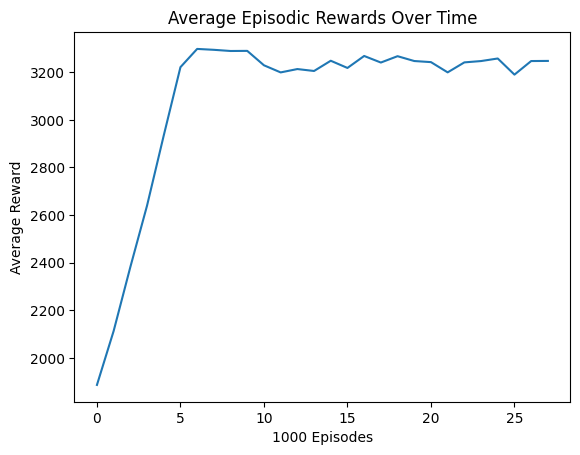

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(



Mean Reward over 100 eval episodes: 3330.00

Best actions by period:
Time Period: 1, Best Action (Discount): 0, State: [648   9   0]
Time Period: 2, Best Action (Discount): 0, State: [558   8   0]
Time Period: 3, Best Action (Discount): 0, State: [470   7   0]
Time Period: 4, Best Action (Discount): 0, State: [387   6   0]
Time Period: 5, Best Action (Discount): 0, State: [303   5   0]
Time Period: 6, Best Action (Discount): 0, State: [224   4   0]
Time Period: 7, Best Action (Discount): 0, State: [148   3   0]
Time Period: 8, Best Action (Discount): 0, State: [73  2  0]
Time Period: 9, Best Action (Discount): 0, State: [1 1 0]
Time Period: 10, Best Action (Discount): 0, State: [0 0 0]
Best action at the last time period: 0
Running sigma=0.02, sigma_d=10


KeyboardInterrupt: 

In [ ]:
sigmas = [0.02, 0.05,0.1]
sigma_ds = [5, 10,15]

results = []

for sigma in sigmas:
    for sigma_d in sigma_ds:
        env_kwargs = {
            'Q0': 740,
            'T': 10,
            'D0': 9.79,
            'alpha': 1.83,
            'beta': 1.83,
            'p': 4.5,
            'Cp': 0.05,
            'C0': 3.5,
            'Cs': 0,
            'q0': 0.95,
            'landa': 0.0067,
            'DD': 8,
            'LC': 0,
            'sigma': sigma,
            'sigma_d': sigma_d
        }

        print(f"Running sigma={sigma}, sigma_d={sigma_d}")
        mean_reward, _ = run_test(env_kwargs, total_timesteps=100000, verbose=0)
        results.append((sigma, sigma_d))
        #print(f"→ Mean Reward: {mean_reward:.2f}")


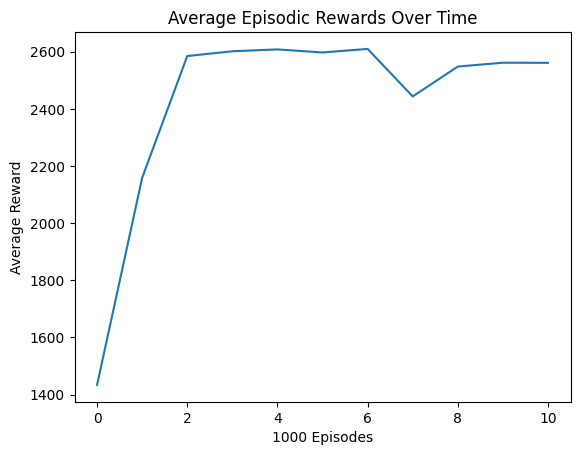


Mean Reward over 100 eval episodes: 2647.76

Best actions by period:
Time Period: 1, Action taken: 0, State: [664   9   0]
Time Period: 2, Action taken: 0, State: [594   8   0]
Time Period: 3, Action taken: 0, State: [529   7   0]
Time Period: 4, Action taken: 0, State: [467   6   0]
Time Period: 5, Action taken: 0, State: [408   5   0]
Time Period: 6, Action taken: 0, State: [351   4   0]
Time Period: 7, Action taken: 0, State: [299   3   0]
Time Period: 8, Action taken: 0, State: [249   2   0]
Time Period: 9, Action taken: 0, State: [200   1   0]
Time Period: 10, Action taken: 0, State: [152   0   0]
Best action at the last time period: 0


(<stable_baselines3.dqn.dqn.DQN at 0x7dbb4a66aad0>,
 <__main__.RewardTrackerCallback at 0x7dbb4a8dced0>)

In [ ]:
run_test(env_kwargs={
    'Q0': 740,
    'T': 10,
    'D0': 9.79,
    'alpha': 1.83,
    'beta': 1.83,
    'p': 4.5,
    'Cp': 0.05,
    'C0': 3.5,
    'Cs': 0,
    'q0': 0.95,
    'landa': 0.0067,
    'DD': 8,
    'LC': 0,
    'sigma': 0.0,
    'sigma_d': 1.6
}, total_timesteps=100000,verbose=0)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.75     |
|    ep_rew_mean      | 1.16e+03 |
|    exploration_rate | 0.999    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2823     |
|    time_elapsed     | 0        |
|    total_timesteps  | 39       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.62     |
|    ep_rew_mean      | 1.21e+03 |
|    exploration_rate | 0.997    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 2686     |
|    time_elapsed     | 0        |
|    total_timesteps  | 77       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.67     |
|    ep_rew_mean      | 1.24e+0

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 2.32     |
|    n_updates        | 34145    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.99     |
|    ep_rew_mean      | 2.63e+03 |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 13756    |
|    fps              | 385      |
|    time_elapsed     | 355      |
|    total_timesteps  | 136723   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.6      |
|    n_updates        | 34155    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10       |
|    ep_rew_mean      | 2.64e+03 |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 13760    |
|   

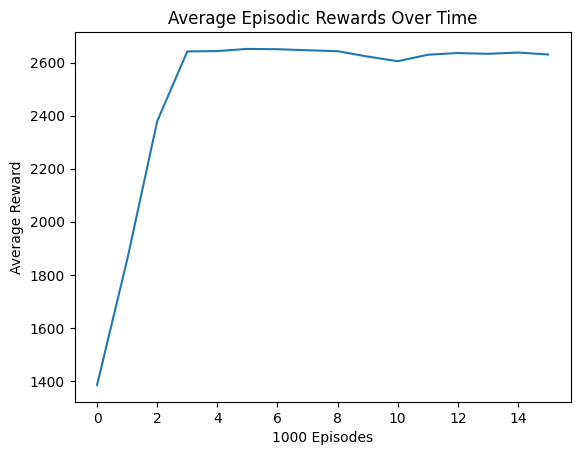

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(



Mean Reward over 100 eval episodes: 2683.30

Best actions by period:
Time Period: 1, Best Action (Discount): 0, State: [665   9   0]
Time Period: 2, Best Action (Discount): 0, State: [595   8   0]
Time Period: 3, Best Action (Discount): 82, State: [530   7   0]
Time Period: 4, Best Action (Discount): 0, State: [469   6   0]
Time Period: 5, Best Action (Discount): 0, State: [412   5   0]
Time Period: 6, Best Action (Discount): 0, State: [358   4   0]
Time Period: 7, Best Action (Discount): 0, State: [306   3   0]
Time Period: 8, Best Action (Discount): 27, State: [203   2  27]
Time Period: 9, Best Action (Discount): 3, State: [102   1  27]
Time Period: 10, Best Action (Discount): 3, State: [ 3  0 27]
Best action at the last time period: 3


(<stable_baselines3.dqn.dqn.DQN at 0x7dbb4a8ae450>,
 <__main__.RewardTrackerCallback at 0x7dbb49794ed0>)

In [ ]:
run_test(env_kwargs={
    'Q0': 740,
    'T': 10,
    'D0': 9.79,
    'alpha': 1.83,
    'beta': 1.83,
    'p': 4.5,
    'Cp': 0.05,
    'C0': 3.5,
    'Cs': 0,
    'q0': 0.95,
    'landa': 0.0067,
    'DD': 8,
    'LC': 0
}, total_timesteps=150000)

In [ ]:
run_test(env_kwargs={
    'Q0': 740,
    'T': 10,
    'D0': 9.79,
    'alpha': 1.83,
    'beta': 1.83,
    'p': 4.5,
    'Cp': 0.05,
    'C0': 3.5,
    'Cs': 0,
    'q0': 0.95,
    'landa': 0.0067,
    'DD': 8,
    'LC': 0,
    'sigma': 0.0,
    'sigma_d': 1.6
}, total_timesteps=100000,verbose=0)

Streaming output truncated to the last 5000 lines.
| train/              |          |
|    learning_rate    | 0.0005   |
|    loss             | 0.31     |
|    n_updates        | 21660    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.95     |
|    ep_rew_mean      | 2.64e+03 |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 8736     |
|    fps              | 382      |
|    time_elapsed     | 227      |
|    total_timesteps  | 86782    |
| train/              |          |
|    learning_rate    | 0.0005   |
|    loss             | 0.484    |
|    n_updates        | 21670    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.95     |
|    ep_rew_mean      | 2.64e+03 |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 8740     |
|   

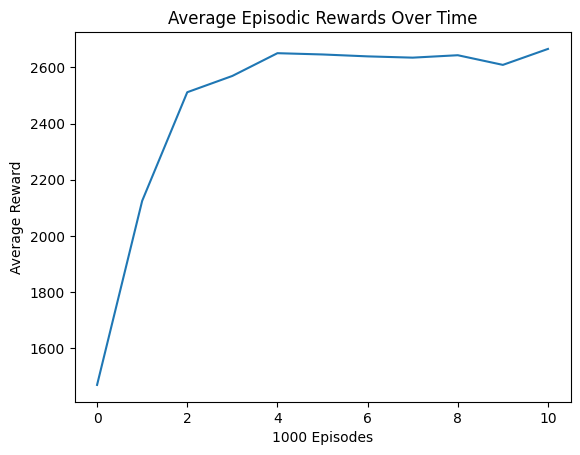


Mean Reward over 100 eval episodes: 2683.30

Best actions by period:
Time Period: 1, Best Action (Discount): 0, State: [665   9   0]
Time Period: 2, Best Action (Discount): 0, State: [595   8   0]
Time Period: 3, Best Action (Discount): 0, State: [530   7   0]
Time Period: 4, Best Action (Discount): 0, State: [469   6   0]
Time Period: 5, Best Action (Discount): 0, State: [412   5   0]
Time Period: 6, Best Action (Discount): 0, State: [358   4   0]
Time Period: 7, Best Action (Discount): 0, State: [306   3   0]
Time Period: 8, Best Action (Discount): 27, State: [203   2  27]
Time Period: 9, Best Action (Discount): 27, State: [102   1  27]
Time Period: 10, Best Action (Discount): 27, State: [ 3  0 27]
Best action at the last time period: 27


(<stable_baselines3.dqn.dqn.DQN at 0x7dbb493b2210>,
 <__main__.RewardTrackerCallback at 0x7dbb495d8850>)

In [ ]:
run_test(env_kwargs={
    'Q0': 740,
    'T': 10,
    'D0': 9.79,
    'alpha': 1.83,
    'beta': 1.83,
    'p': 4.5,
    'Cp': 0.05,
    'C0': 3.5,
    'Cs': 0,
    'q0': 0.95,
    'landa': 0.0067,
    'DD': 8,
    'LC': 0
}, total_timesteps=100000)

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


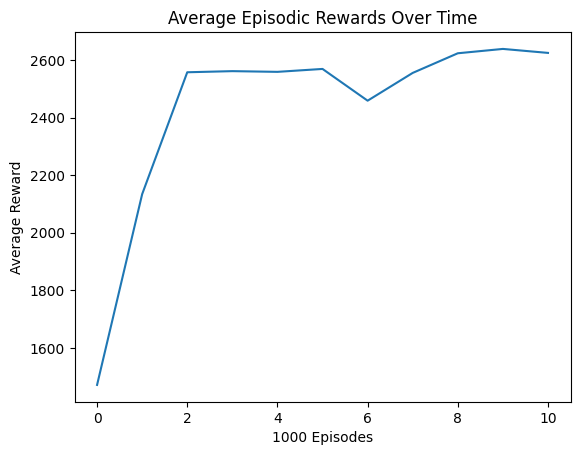

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(



Mean Reward over 100 eval episodes: 2670.68

Best actions by period:
Time Period: 1, Best Action (Discount): 0, State: [665   9   0]
Time Period: 2, Best Action (Discount): 0, State: [595   8   0]
Time Period: 3, Best Action (Discount): 0, State: [531   7   0]
Time Period: 4, Best Action (Discount): 0, State: [471   6   0]
Time Period: 5, Best Action (Discount): 0, State: [414   5   0]
Time Period: 6, Best Action (Discount): 0, State: [360   4   0]
Time Period: 7, Best Action (Discount): 0, State: [309   3   0]
Time Period: 8, Best Action (Discount): 26, State: [208   2  26]
Time Period: 9, Best Action (Discount): 0, State: [109   1  26]
Time Period: 10, Best Action (Discount): 0, State: [13  0 26]
Best action at the last time period: 0


(<stable_baselines3.dqn.dqn.DQN at 0x7dbb49371590>,
 <__main__.RewardTrackerCallback at 0x7dbb495dbe90>)

In [ ]:
run_test(env_kwargs={
    'Q0': 740,
    'T': 10,
    'D0': 9.79,
    'alpha': 1.83,
    'beta': 1.83,
    'p': 4.5,
    'Cp': 0.05,
    'C0': 3.5,
    'Cs': 0,
    'q0': 0.95,
    'landa': 0.0067,
    'DD': 8,
    'LC': 0,
    'sigma': 0.0,
    'sigma_d': 0.8
}, total_timesteps=100000,verbose=0)

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


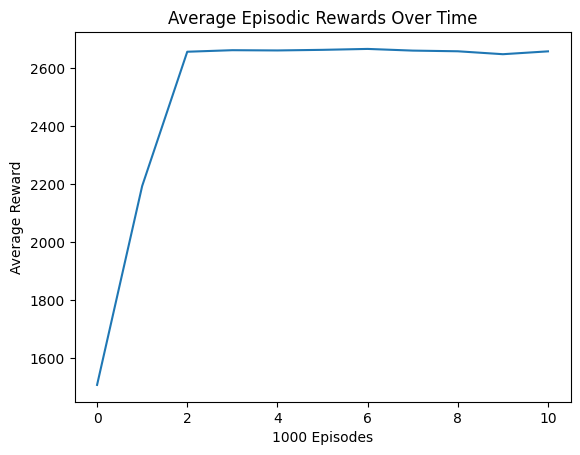

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(



Mean Reward over 100 eval episodes: 2700.12

Best actions by period:
Time Period: 1, Action taken: 0, State: [662   9   0]
Time Period: 2, Action taken: 0, State: [593   8   0]
Time Period: 3, Action taken: 0, State: [527   7   0]
Time Period: 4, Action taken: 0, State: [465   6   0]
Time Period: 5, Action taken: 0, State: [406   5   0]
Time Period: 6, Action taken: 0, State: [350   4   0]
Time Period: 7, Action taken: 0, State: [297   3   0]
Time Period: 8, Action taken: 25, State: [200   2  25]
Time Period: 9, Action taken: 25, State: [103   1  25]
Time Period: 10, Action taken: 25, State: [11  0 25]
Best action at the last time period: 96


(<stable_baselines3.dqn.dqn.DQN at 0x7f38628df6d0>,
 <__main__.RewardTrackerCallback at 0x7f3861c27590>)

In [ ]:
run_test(env_kwargs={
    'Q0': 740,
    'T': 10,
    'D0': 9.79,
    'alpha': 1.83,
    'beta': 1.83,
    'p': 4.5,
    'Cp': 0.05,
    'C0': 3.5,
    'Cs': 0,
    'q0': 0.95,
    'landa': 0.0067,
    'DD': 8,
    'LC': 0,
    'sigma': 0.0,
    'sigma_d': 1.64
}, total_timesteps=100000,verbose=0)

Streaming output truncated to the last 5000 lines.
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 4.09     |
|    n_updates        | 21641    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.99     |
|    ep_rew_mean      | 2.74e+03 |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 8744     |
|    fps              | 429      |
|    time_elapsed     | 201      |
|    total_timesteps  | 86707    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 5.23     |
|    n_updates        | 21651    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.99     |
|    ep_rew_mean      | 2.74e+03 |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 8748     |
|   

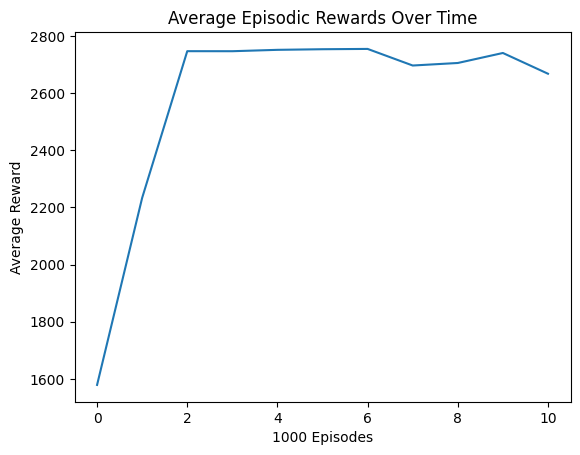


Mean Reward over 100 eval episodes: 2779.36

Best actions by period:
Time Period: 1, Action taken: 0, State: [661   9   0]
Time Period: 2, Action taken: 0, State: [585   8   0]
Time Period: 3, Action taken: 0, State: [516   7   0]
Time Period: 4, Action taken: 0, State: [450   6   0]
Time Period: 5, Action taken: 0, State: [388   5   0]
Time Period: 6, Action taken: 0, State: [328   4   0]
Time Period: 7, Action taken: 0, State: [271   3   0]
Time Period: 8, Action taken: 23, State: [175   2  23]
Time Period: 9, Action taken: 23, State: [82  1 23]
Time Period: 10, Action taken: 23, State: [ 0  0 23]
Best action at the last time period: 4


(<stable_baselines3.dqn.dqn.DQN at 0x7f3858620d10>,
 <__main__.RewardTrackerCallback at 0x7f385574f0d0>)

In [ ]:
run_test(env_kwargs={
    'Q0': 740,
    'T': 10,
    'D0': 9.79,
    'alpha': 1.83,
    'beta': 1.83,
    'p': 4.5,
    'Cp': 0.05,
    'C0': 3.5,
    'Cs': 0,
    'q0': 0.95,
    'landa': 0.0067,
    'DD': 8,
    'LC': 0,
    'sigma': 0.0,
    'sigma_d': 2.47
}, total_timesteps=100000,verbose=2)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.5      |
|    ep_rew_mean      | 1.56e+03 |
|    exploration_rate | 0.998    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1659     |
|    time_elapsed     | 0        |
|    total_timesteps  | 38       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.25     |
|    ep_rew_mean      | 1.43e+03 |
|    exploration_rate | 0.996    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1714     |
|    time_elapsed     | 0        |
|    total_timesteps  | 74       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.33     |
|    ep_rew_mean      | 1.5e+03

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 21.4     |
|    n_updates        | 21644    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.98     |
|    ep_rew_mean      | 2.81e+03 |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 8764     |
|    fps              | 439      |
|    time_elapsed     | 197      |
|    total_timesteps  | 86717    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 10       |
|    n_updates        | 21654    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.98     |
|    ep_rew_mean      | 2.8e+03  |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 8768     |
|   

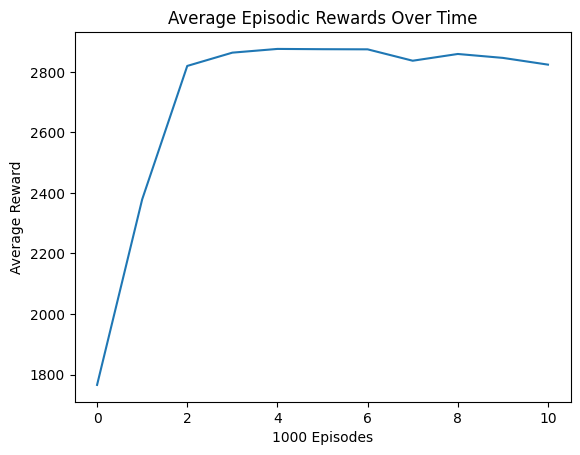

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(



Mean Reward over 100 eval episodes: 2922.53

Best actions by period:
Time Period: 1, Action taken: 0, State: [660   9   0]
Time Period: 2, Action taken: 0, State: [580   8   0]
Time Period: 3, Action taken: 0, State: [506   7   0]
Time Period: 4, Action taken: 0, State: [435   6   0]
Time Period: 5, Action taken: 0, State: [368   5   0]
Time Period: 6, Action taken: 0, State: [301   4   0]
Time Period: 7, Action taken: 0, State: [239   3   0]
Time Period: 8, Action taken: 11, State: [162   2  11]
Time Period: 9, Action taken: 11, State: [84  1 11]
Time Period: 10, Action taken: 11, State: [ 7  0 11]
Best action at the last time period: 67


(<stable_baselines3.dqn.dqn.DQN at 0x7f3860958d10>,
 <__main__.RewardTrackerCallback at 0x7f385555be90>)

In [ ]:
run_test(env_kwargs={
    'Q0': 740,
    'T': 10,
    'D0': 9.79,
    'alpha': 1.83,
    'beta': 1.83,
    'p': 4.5,
    'Cp': 0.05,
    'C0': 3.5,
    'Cs': 0,
    'q0': 0.95,
    'landa': 0.0067,
    'DD': 8,
    'LC': 0,
    'sigma': 0.0,
    'sigma_d': 3.29
}, total_timesteps=100000,verbose=2)

Streaming output truncated to the last 5000 lines.
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 7.49     |
|    n_updates        | 21645    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.98     |
|    ep_rew_mean      | 2.89e+03 |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 8772     |
|    fps              | 431      |
|    time_elapsed     | 201      |
|    total_timesteps  | 86724    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 5.59     |
|    n_updates        | 21655    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.98     |
|    ep_rew_mean      | 2.89e+03 |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 8776     |
|   

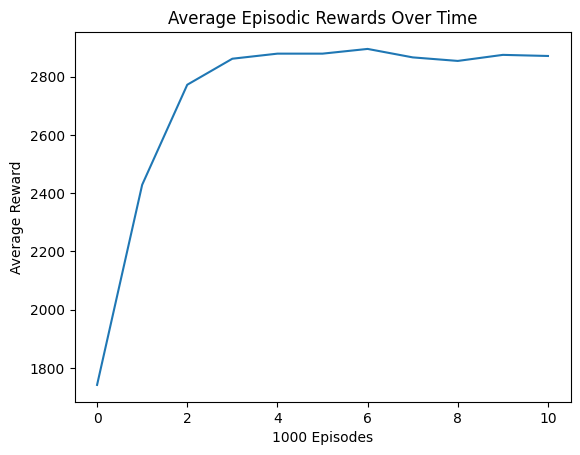


Mean Reward over 100 eval episodes: 2927.49

Best actions by period:
Time Period: 1, Action taken: 0, State: [659   9   0]
Time Period: 2, Action taken: 0, State: [583   8   0]
Time Period: 3, Action taken: 0, State: [509   7   0]
Time Period: 4, Action taken: 0, State: [439   6   0]
Time Period: 5, Action taken: 0, State: [371   5   0]
Time Period: 6, Action taken: 0, State: [306   4   0]
Time Period: 7, Action taken: 0, State: [244   3   0]
Time Period: 8, Action taken: 12, State: [160   2  12]
Time Period: 9, Action taken: 12, State: [80  1 12]
Time Period: 10, Action taken: 12, State: [ 7  0 12]
Best action at the last time period: 6


(<stable_baselines3.dqn.dqn.DQN at 0x7f38556f0d10>,
 <__main__.RewardTrackerCallback at 0x7f3855561650>)

In [ ]:
run_test(env_kwargs={
    'Q0': 740,
    'T': 10,
    'D0': 9.79,
    'alpha': 1.83,
    'beta': 1.83,
    'p': 4.5,
    'Cp': 0.05,
    'C0': 3.5,
    'Cs': 0,
    'q0': 0.95,
    'landa': 0.0067,
    'DD': 8,
    'LC': 0,
    'sigma': 0.0,
    'sigma_d': 3.29
}, total_timesteps=100000,verbose=2)

diff configurations

Streaming output truncated to the last 5000 lines.
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0166   |
|    n_updates        | 23974    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3        |
|    ep_rew_mean      | 316      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 32004    |
|    fps              | 378      |
|    time_elapsed     | 253      |
|    total_timesteps  | 96012    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00279  |
|    n_updates        | 23977    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3        |
|    ep_rew_mean      | 316      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 32008    |
|   

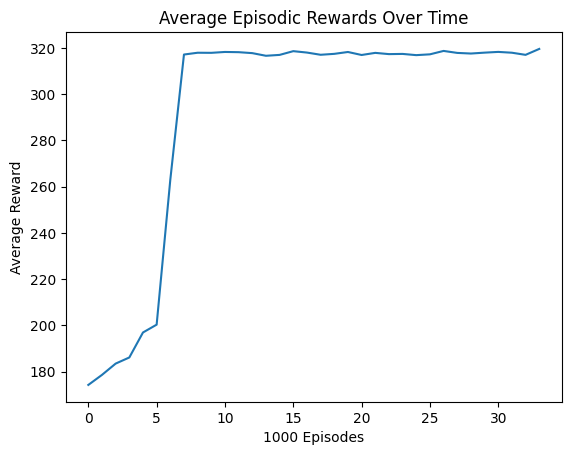


Mean Reward over 100 eval episodes: 320.92

Best actions by period:
Time Period: 1, Action taken: 0, State: [156   2   0]
Time Period: 2, Action taken: 0, State: [100   1   0]
Time Period: 3, Action taken: 34, State: [11  0 34]
Best action at the last time period: 34


(<stable_baselines3.dqn.dqn.DQN at 0x7f38550bfc90>,
 <__main__.RewardTrackerCallback at 0x7f38550c0050>)

In [ ]:
run_test(env_kwargs={
}, total_timesteps=100000,verbose=2)

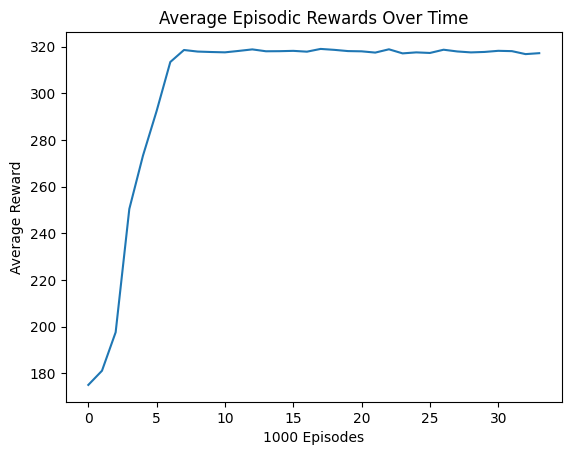


Mean Reward over 100 eval episodes: 321.39

Best actions by period:
Time Period: 1, Action taken: 0, State: [156   2   0]
Time Period: 2, Action taken: 0, State: [100   1   0]
Time Period: 3, Action taken: 36, State: [ 8  0 36]
Best action at the last time period: 36


(<stable_baselines3.dqn.dqn.DQN at 0x7f38550adb10>,
 <__main__.RewardTrackerCallback at 0x7f38553dc550>)

In [ ]:
run_test(env_kwargs={
    'sigma_d': 1.09
}, total_timesteps=100000,verbose=0)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3        |
|    ep_rew_mean      | 184      |
|    exploration_rate | 0.999    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1852     |
|    time_elapsed     | 0        |
|    total_timesteps  | 12       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3        |
|    ep_rew_mean      | 169      |
|    exploration_rate | 0.999    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1712     |
|    time_elapsed     | 0        |
|    total_timesteps  | 24       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3        |
|    ep_rew_mean      | 171    

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.858    |
|    n_updates        | 23974    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3        |
|    ep_rew_mean      | 328      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 32004    |
|    fps              | 357      |
|    time_elapsed     | 268      |
|    total_timesteps  | 96012    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.69     |
|    n_updates        | 23977    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3        |
|    ep_rew_mean      | 328      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 32008    |
|   

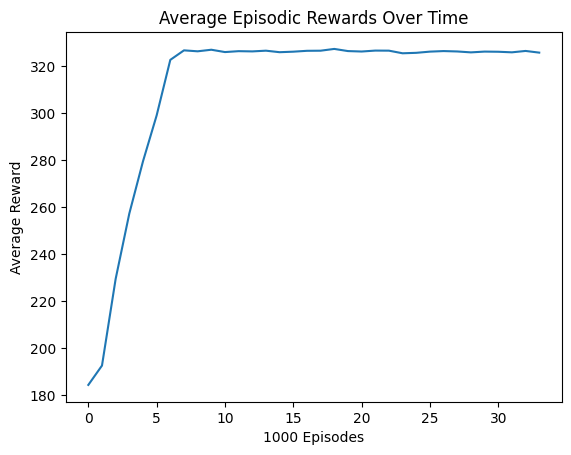

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(



Mean Reward over 100 eval episodes: 329.31

Best actions by period:
Time Period: 1, Action taken: 0, State: [154   2   0]
Time Period: 2, Action taken: 0, State: [93  1  0]
Time Period: 3, Action taken: 31, State: [ 7  0 31]
Best action at the last time period: 31


(<stable_baselines3.dqn.dqn.DQN at 0x7f385509f110>,
 <__main__.RewardTrackerCallback at 0x7f3854e58210>)

In [ ]:
run_test(env_kwargs={
    'sigma_d': 2.18
}, total_timesteps=100000,verbose=2)

Streaming output truncated to the last 5000 lines.
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 2.62     |
|    n_updates        | 21645    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10       |
|    ep_rew_mean      | 2.57e+03 |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 8728     |
|    fps              | 450      |
|    time_elapsed     | 192      |
|    total_timesteps  | 86723    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.91     |
|    n_updates        | 21655    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10       |
|    ep_rew_mean      | 2.57e+03 |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 8732     |
|   

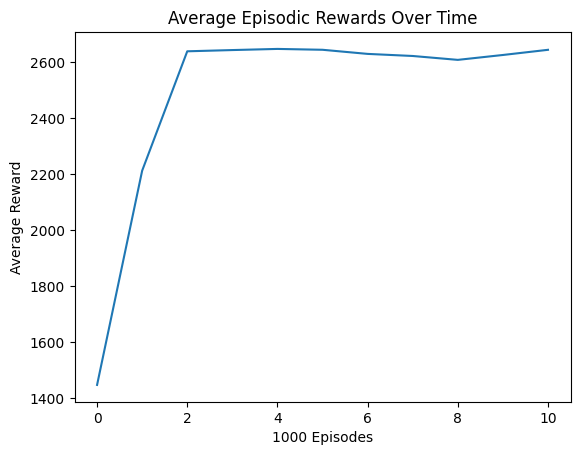


Mean Reward over 100 eval episodes: 2665.01

Best actions by period:
Time Period: 1, Action taken: 0, State: [665   9   0]
Time Period: 2, Action taken: 0, State: [595   8   0]
Time Period: 3, Action taken: 0, State: [530   7   0]
Time Period: 4, Action taken: 0, State: [469   6   0]
Time Period: 5, Action taken: 0, State: [412   5   0]
Time Period: 6, Action taken: 0, State: [358   4   0]
Time Period: 7, Action taken: 0, State: [306   3   0]
Time Period: 8, Action taken: 29, State: [199   2  29]
Time Period: 9, Action taken: 29, State: [94  1 29]
Time Period: 10, Action taken: 29, State: [ 0  0 29]


(<stable_baselines3.dqn.dqn.DQN at 0x7d8579b67a90>,
 <__main__.RewardTrackerCallback at 0x7d857bdc2650>)

In [ ]:
run_test(env_kwargs={
    'Q0': 740,
    'T': 10,
    'D0': 9.79,
    'alpha': 1.83,
    'beta': 1.83,
    'p': 4.5,
    'Cp': 0.05,
    'C0': 3.5,
    'Cs': 0,
    'q0': 0.95,
    'landa': 0.0067,
    'DD': 8,
    'LC': 0,
    'sigma': 0.05,
    'sigma_d': 0.0
}, total_timesteps=100000,verbose=2)

Streaming output truncated to the last 5000 lines.
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 10.6     |
|    n_updates        | 21640    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.99     |
|    ep_rew_mean      | 2.66e+03 |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 8748     |
|    fps              | 440      |
|    time_elapsed     | 196      |
|    total_timesteps  | 86701    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 2.74     |
|    n_updates        | 21650    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.99     |
|    ep_rew_mean      | 2.66e+03 |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 8752     |
|   

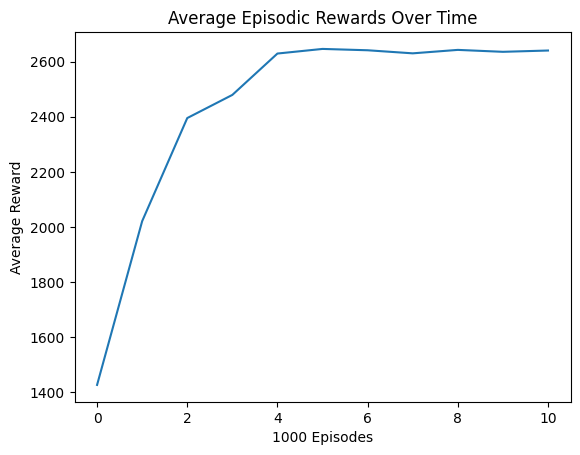


Mean Reward over 100 eval episodes: 2677.35

Best actions by period:
Time Period: 1, Action taken: 0, State: [664   9   0]
Time Period: 2, Action taken: 0, State: [594   8   0]
Time Period: 3, Action taken: 0, State: [529   7   0]
Time Period: 4, Action taken: 0, State: [468   6   0]
Time Period: 5, Action taken: 0, State: [411   5   0]
Time Period: 6, Action taken: 0, State: [357   4   0]
Time Period: 7, Action taken: 0, State: [306   3   0]
Time Period: 8, Action taken: 27, State: [204   2  27]
Time Period: 9, Action taken: 27, State: [102   1  27]
Time Period: 10, Action taken: 27, State: [ 3  0 27]


(<stable_baselines3.dqn.dqn.DQN at 0x7d857bfcc510>,
 <__main__.RewardTrackerCallback at 0x7d857bc1dad0>)

In [ ]:
run_test(env_kwargs={
    'Q0': 740,
    'T': 10,
    'D0': 9.79,
    'alpha': 1.83,
    'beta': 1.83,
    'p': 4.5,
    'Cp': 0.05,
    'C0': 3.5,
    'Cs': 0,
    'q0': 0.95,
    'landa': 0.0067,
    'DD': 8,
    'LC': 0,
    'sigma': 0.05,
    'sigma_d': 0.82
}, total_timesteps=100000,verbose=2)

Streaming output truncated to the last 5000 lines.
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.969    |
|    n_updates        | 21638    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.98     |
|    ep_rew_mean      | 2.05e+03 |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 8724     |
|    fps              | 451      |
|    time_elapsed     | 191      |
|    total_timesteps  | 86693    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.08     |
|    n_updates        | 21648    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.98     |
|    ep_rew_mean      | 2.07e+03 |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 8728     |
|   

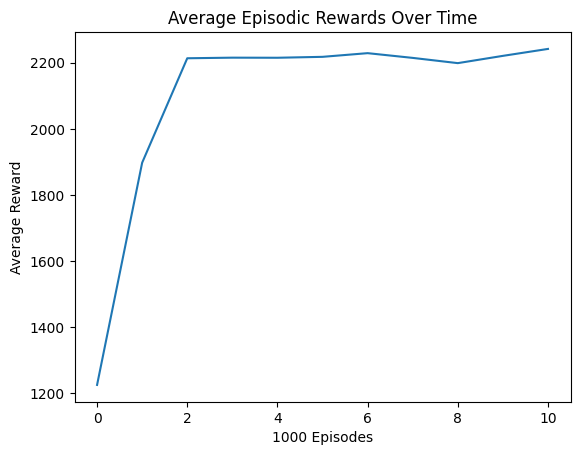


Mean Reward over 100 eval episodes: 2262.14

Best actions by period:
Time Period: 1, Action taken: 0, State: [566   9   0]
Time Period: 2, Action taken: 0, State: [507   8   0]
Time Period: 3, Action taken: 0, State: [452   7   0]
Time Period: 4, Action taken: 0, State: [401   6   0]
Time Period: 5, Action taken: 0, State: [353   5   0]
Time Period: 6, Action taken: 0, State: [307   4   0]
Time Period: 7, Action taken: 0, State: [264   3   0]
Time Period: 8, Action taken: 27, State: [177   2  27]
Time Period: 9, Action taken: 27, State: [92  1 27]
Time Period: 10, Action taken: 27, State: [ 8  0 27]


(<stable_baselines3.dqn.dqn.DQN at 0x7d857bcd10d0>,
 <__main__.RewardTrackerCallback at 0x7d857bd889d0>)

In [ ]:
run_test(env_kwargs={'Q0':630, 'T':10, 'D0':8.32, 'alpha':1.56, 'beta':1.56, 'p':4.5, 'Cp':0.05, 'C0':3.5, 'Cs':0, 'q0':0.97, 'landa':0.0067, 'DD':8, 'LC':0}, total_timesteps=100000)

Streaming output truncated to the last 5000 lines.
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.46     |
|    n_updates        | 21638    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.97     |
|    ep_rew_mean      | 3.34e+03 |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 8736     |
|    fps              | 407      |
|    time_elapsed     | 212      |
|    total_timesteps  | 86696    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 2.25     |
|    n_updates        | 21648    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.98     |
|    ep_rew_mean      | 3.35e+03 |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 8740     |
|   

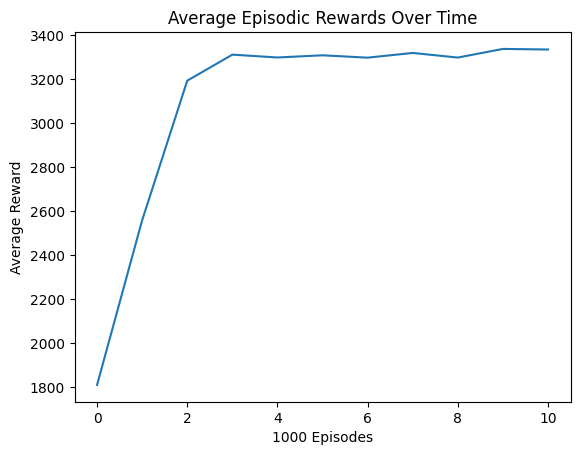


Mean Reward over 100 eval episodes: 3383.84

Best actions by period:
Time Period: 1, Action taken: 0, State: [856   9   0]
Time Period: 2, Action taken: 0, State: [768   8   0]
Time Period: 3, Action taken: 0, State: [686   7   0]
Time Period: 4, Action taken: 0, State: [609   6   0]
Time Period: 5, Action taken: 0, State: [537   5   0]
Time Period: 6, Action taken: 0, State: [468   4   0]
Time Period: 7, Action taken: 0, State: [402   3   0]
Time Period: 8, Action taken: 24, State: [277   2  24]
Time Period: 9, Action taken: 24, State: [155   1  24]
Time Period: 10, Action taken: 24, State: [34  0 24]


(<stable_baselines3.dqn.dqn.DQN at 0x7d8579af17d0>,
 <__main__.RewardTrackerCallback at 0x7d8579adda90>)

In [ ]:
run_test(env_kwargs={'Q0':950, 'T':10, 'D0':12.73, 'alpha':2.38, 'beta':2.38, 'p':4.5, 'Cp':0.05, 'C0':3.5, 'Cs':0, 'q0':0.88, 'landa':0.0067, 'DD':8, 'LC':0}, total_timesteps=100000)


Streaming output truncated to the last 5000 lines.
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.61     |
|    n_updates        | 21640    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10       |
|    ep_rew_mean      | 2.03e+03 |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 8724     |
|    fps              | 438      |
|    time_elapsed     | 197      |
|    total_timesteps  | 86703    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 2.05     |
|    n_updates        | 21650    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10       |
|    ep_rew_mean      | 2.03e+03 |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 8728     |
|   

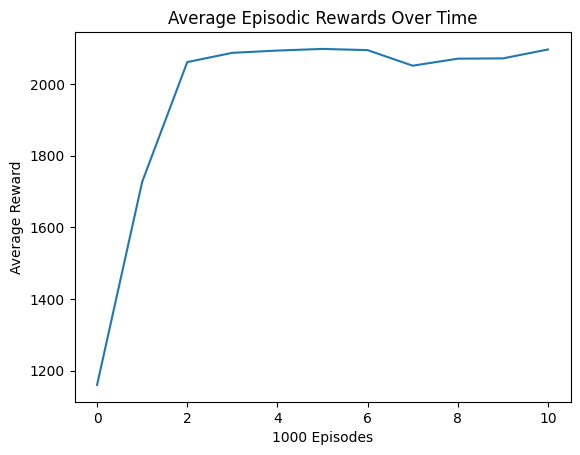


Mean Reward over 100 eval episodes: 2119.83

Best actions by period:
Time Period: 1, Action taken: 0, State: [531   9   0]
Time Period: 2, Action taken: 0, State: [476   8   0]
Time Period: 3, Action taken: 0, State: [425   7   0]
Time Period: 4, Action taken: 0, State: [377   6   0]
Time Period: 5, Action taken: 0, State: [332   5   0]
Time Period: 6, Action taken: 0, State: [289   4   0]
Time Period: 7, Action taken: 0, State: [248   3   0]
Time Period: 8, Action taken: 29, State: [163   2  29]
Time Period: 9, Action taken: 29, State: [79  1 29]
Time Period: 10, Action taken: 29, State: [ 0  0 29]


(<stable_baselines3.dqn.dqn.DQN at 0x7d8579a16890>,
 <__main__.RewardTrackerCallback at 0x7d8579477650>)

In [ ]:



run_test(env_kwargs={'Q0':590, 'T':10, 'D0':7.83, 'alpha':1.46, 'beta':1.46, 'p':4.5, 'Cp':0.05, 'C0':3.5, 'Cs':0, 'q0':0.90, 'landa':0.0067, 'DD':8, 'LC':0}, total_timesteps=100000)

Streaming output truncated to the last 5000 lines.
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.179    |
|    n_updates        | 23974    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3        |
|    ep_rew_mean      | 319      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 32004    |
|    fps              | 425      |
|    time_elapsed     | 225      |
|    total_timesteps  | 96012    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0126   |
|    n_updates        | 23977    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3        |
|    ep_rew_mean      | 319      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 32008    |
|   

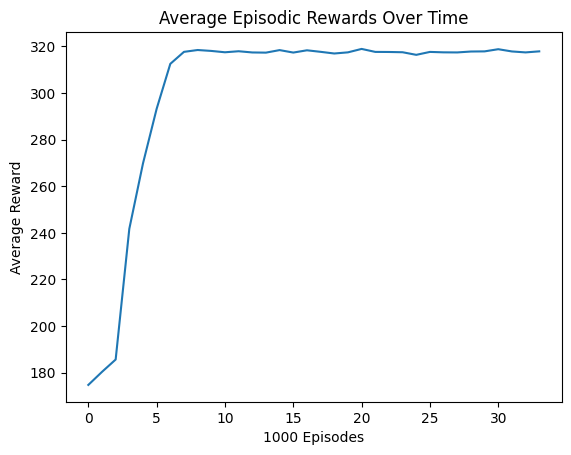

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(



Mean Reward over 100 eval episodes: 320.65

Best actions by period:
Time Period: 1, Action taken: 0, State: [156   2   0]
Time Period: 2, Action taken: 0, State: [100   1   0]
Time Period: 3, Action taken: 39, State: [ 4  0 39]


(<stable_baselines3.dqn.dqn.DQN at 0x7ed8a5d82450>,
 <__main__.RewardTrackerCallback at 0x7ed89b5bda50>)

In [ ]:
run_test(env_kwargs={}, total_timesteps=100000,verbose=2)

Streaming output truncated to the last 5000 lines.
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0447   |
|    n_updates        | 23974    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3        |
|    ep_rew_mean      | 318      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 32004    |
|    fps              | 408      |
|    time_elapsed     | 234      |
|    total_timesteps  | 96012    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0457   |
|    n_updates        | 23977    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3        |
|    ep_rew_mean      | 318      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 32008    |
|   

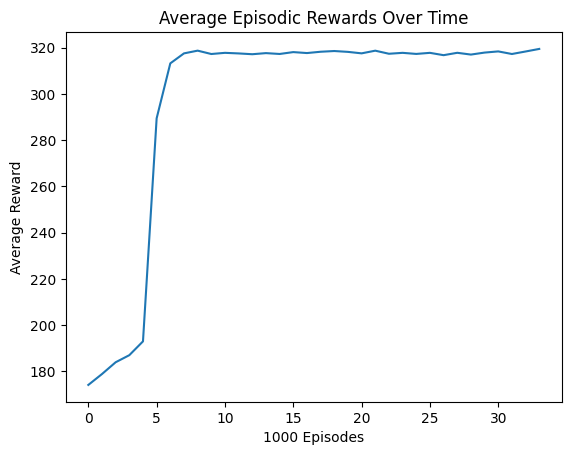


Mean Reward over 100 eval episodes: 321.16

Best actions by period:
Time Period: 1, Action taken: 0, State: [156   2   0]
Time Period: 2, Action taken: 0, State: [100   1   0]
Time Period: 3, Action taken: 38, State: [ 5  0 38]


(<stable_baselines3.dqn.dqn.DQN at 0x7ed89b192f90>,
 <__main__.RewardTrackerCallback at 0x7ed89b3b5a50>)

In [ ]:
run_test(env_kwargs={}, total_timesteps=100000,verbose=2)

Streaming output truncated to the last 5000 lines.
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0902   |
|    n_updates        | 23981    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.99     |
|    ep_rew_mean      | 291      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 33360    |
|    fps              | 412      |
|    time_elapsed     | 232      |
|    total_timesteps  | 96037    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.515    |
|    n_updates        | 23984    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.99     |
|    ep_rew_mean      | 291      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 33364    |
|   

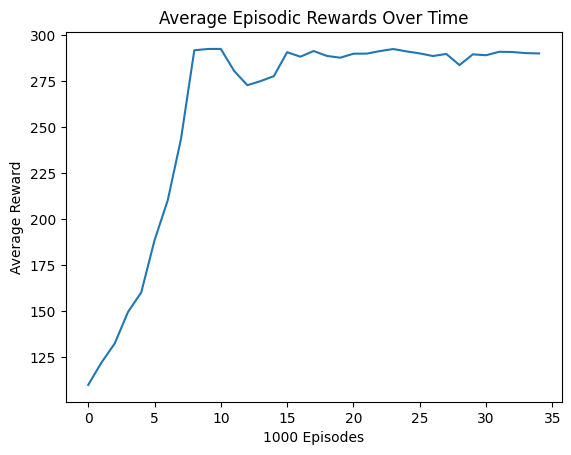


Mean Reward over 100 eval episodes: 294.24

Best actions by period:
Time Period: 1, Action taken: 0, State: [156   2   0]
Time Period: 2, Action taken: 17, State: [75  1 17]
Time Period: 3, Action taken: 28, State: [ 0  0 28]


(<stable_baselines3.dqn.dqn.DQN at 0x7f7633cb4d10>,
 <__main__.RewardTrackerCallback at 0x7f7634d01e10>)

In [ ]:
run_test(env_kwargs={
    'DD': None,
}, total_timesteps=100000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.25     |
|    ep_rew_mean      | 159      |
|    exploration_rate | 1        |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1915     |
|    time_elapsed     | 0        |
|    total_timesteps  | 9        |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.5      |
|    ep_rew_mean      | 184      |
|    exploration_rate | 0.999    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1958     |
|    time_elapsed     | 0        |
|    total_timesteps  | 20       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.67     |
|    ep_rew_mean      | 203    

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.03     |
|    n_updates        | 23975    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3        |
|    ep_rew_mean      | 353      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 32436    |
|    fps              | 413      |
|    time_elapsed     | 232      |
|    total_timesteps  | 96014    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.189    |
|    n_updates        | 23978    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3        |
|    ep_rew_mean      | 355      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 32440    |
|   

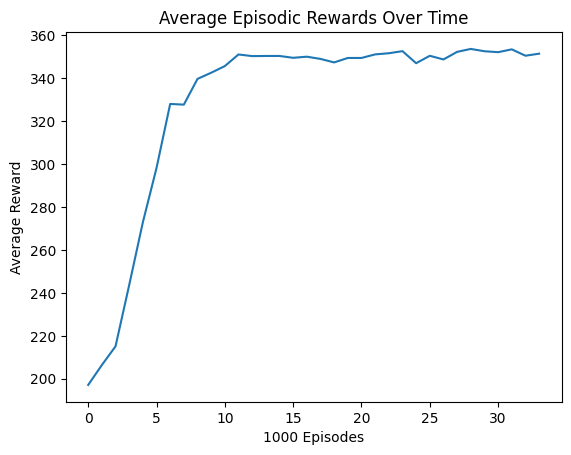

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(



Mean Reward over 100 eval episodes: 357.14

Best actions by period:
Time Period: 1, Action taken: 0, State: [156   2   0]
Time Period: 2, Action taken: 21, State: [69  1 21]
Time Period: 3, Action taken: 21, State: [ 0  0 21]


(<stable_baselines3.dqn.dqn.DQN at 0x7f7633644a90>,
 <__main__.RewardTrackerCallback at 0x7f7633679c50>)

In [ ]:
run_test(env_kwargs={
    'DD': [2,3],
}, total_timesteps=100000)

Streaming output truncated to the last 5000 lines.
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.347    |
|    n_updates        | 23980    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.99     |
|    ep_rew_mean      | 373      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 33348    |
|    fps              | 426      |
|    time_elapsed     | 225      |
|    total_timesteps  | 96033    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.49     |
|    n_updates        | 23983    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.99     |
|    ep_rew_mean      | 374      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 33352    |
|   

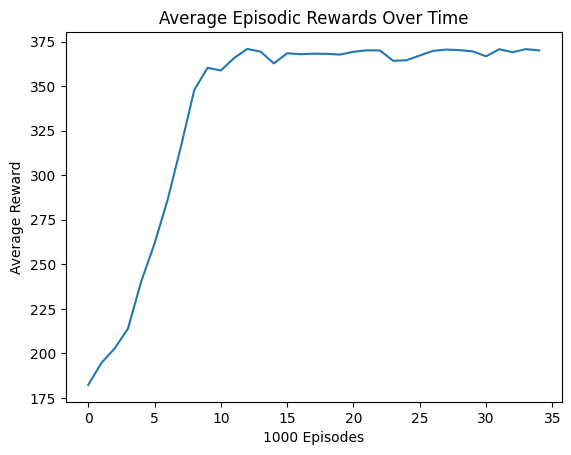


Mean Reward over 100 eval episodes: 377.91

Best actions by period:
Time Period: 1, Action taken: 7, State: [145   2   7]
Time Period: 2, Action taken: 13, State: [70  1 13]
Time Period: 3, Action taken: 21, State: [ 0  0 21]


(<stable_baselines3.dqn.dqn.DQN at 0x7f7633646890>,
 <__main__.RewardTrackerCallback at 0x7f7634c54c50>)

In [ ]:
run_test(env_kwargs={
    'DD': [1,2,3],
}, total_timesteps=100000)